In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from src.data.make_dataset import import_data
from src.features.build_features import features,split_data,feature_engineering
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
pd.options.display.max_columns =70

# I. Import dataset

In [15]:
df=import_data()

In [16]:
df=df.reset_index()

# II. Preprocess dataset

In [17]:
df=features(df)

In [18]:
df

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,487,12198,0.125,30,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28830,8,900,2812,0.125,10,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,94947,21,363,8973,0.125,10,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,590882,22,418,10694,0.125,10,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,201944,11,131,1488,0.250,30,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,0.250,70,0.191919,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
347465,663567,10,1407,11907,0.250,25,0.050505,0.166667,1,1,1,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
347466,1049160,22,1136,7712,0.000,50,0.020202,0.033333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
347467,442785,6,1041,912,0.125,5,0.080808,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,0.

# III. Feature Selection and Rebalancing

## Korrelation Heatmap 

<ipython-input-8-cc8606d872f0>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


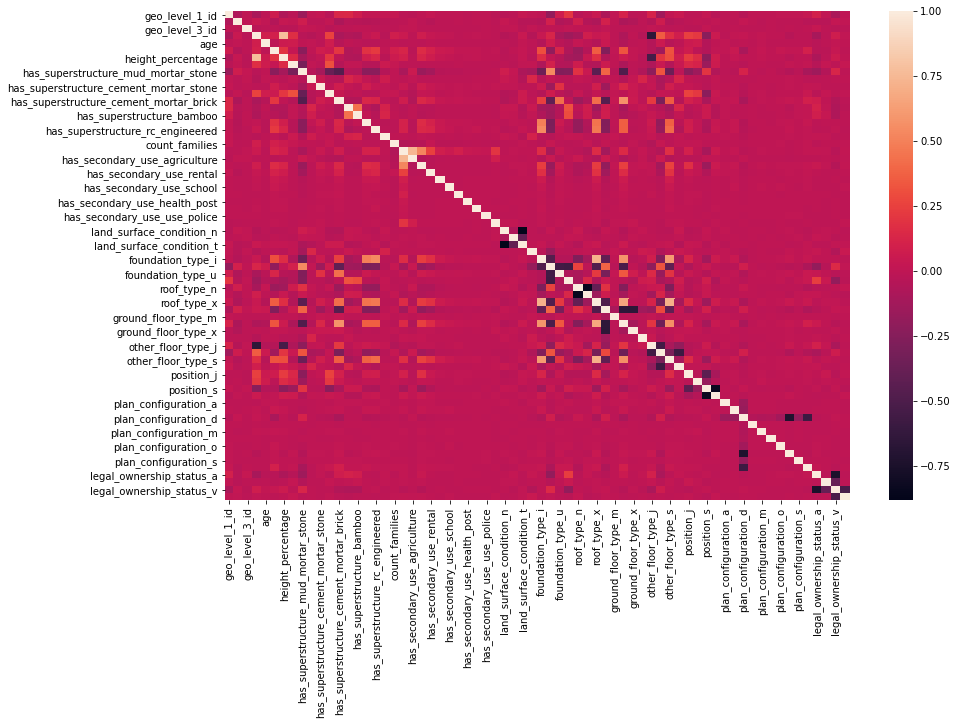

In [8]:
corrMatrix=df.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [9]:
#Korrelation
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
data_train=data_train.drop(columns=correlated_features)

The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: position_t and position_s. Correlation = 0.82
Drop the following features: {'land_surface_condition_t', 'roof_type_q', 'position_t'}


je nach Modell beachten

# IV. Split dataset back into train and test set


In [6]:
data_train, target_train, data_test = split_data(df)
data_train

# V. Model building - Baselines

## Train-Test-Split

In [10]:
#scale geo_features for logistic regression and runtime
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id','age']
scaler = MinMaxScaler()
data_train[geo_features] = scaler.fit_transform(data_train[geo_features])
data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28830,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
94947,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
590882,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
201944,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,0.833333,0.935529,0.128989,0.000,0.055276,0.050505,0.033333,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
669485,0.566667,0.501051,0.163921,0.125,0.000000,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
602512,0.566667,0.035739,0.649558,0.250,0.055276,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42)

## Rebalance Train set

Text(0, 0.5, 'Frequency')

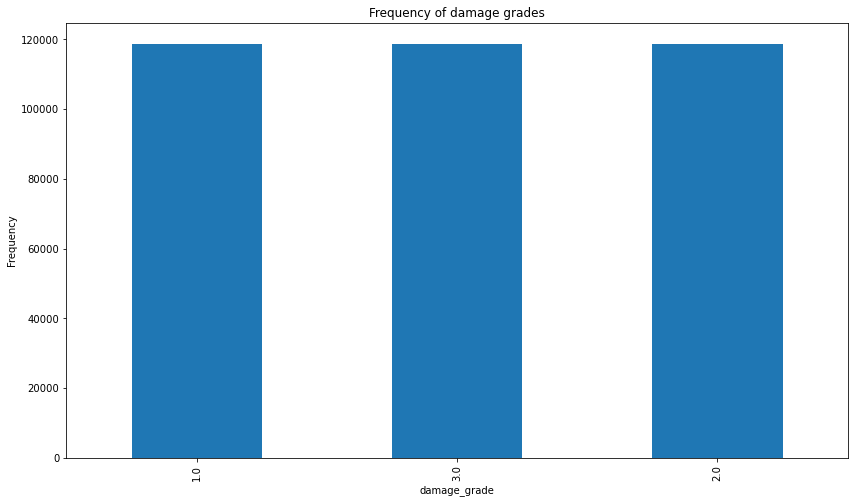

In [12]:
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

In [13]:
train_balanced_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,0.433333,0.180098,0.664598,0.250,0.025126,0.010101,0.100000,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.200000,0.754029,0.732235,0.250,0.040201,0.090909,0.200000,0,1,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.233333,0.587246,0.853266,0.125,0.045226,0.070707,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.233333,0.388928,0.219862,0.125,0.030151,0.060606,0.066667,0,1,0,1,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.566667,0.477926,0.082677,0.250,0.030151,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356311,0.333333,0.088998,0.104003,0.125,0.005025,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
356312,0.233333,0.432376,0.184053,0.125,0.000000,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
356313,0.333333,0.422565,0.962919,0.125,0.015075,0.090909,0.066667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
356314,0.766667,0.625788,0.132251,0.250,0.025126,0.080808,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

# Decision Tree

## ohne Rebalance

In [14]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6567
The F1-Score micro on test set: 0.6567
The F1-Score macro on test set: 0.6090
The Precision-Score on test set: 0.6567
The Recall-Score on test set: 0.6567
Confusion Matrix : 
[[ 2640  2191   339]
 [ 2340 20863  6284]
 [  355  6384 10725]]


## mit Rebalance

In [15]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6531
The F1-Score micro on test set: 0.6531
The F1-Score macro on test set: 0.6032
The Precision-Score on test set: 0.6531
The Recall-Score on test set: 0.6531
Confusion Matrix : 
[[ 2521  2335   314]
 [ 2243 20793  6451]
 [  323  6417 10724]]


# Logistic Regression

## ohne Rebalance

In [16]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.5881
The F1-Score micro on test set: 0.5881
The F1-Score macro on test set: 0.4631
The Precision-Score on test set: 0.5881
The Recall-Score on test set: 0.5881
Confusion Matrix : 
[[ 1524  3518   128]
 [  968 25681  2838]
 [   91 13926  3447]]


## mit Rebalance

In [17]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

The Accuracy on test set: 0.5069
The F1-Score micro on test set: 0.5069
The F1-Score macro on test set: 0.5046
The Precision-Score on test set: 0.5069
The Recall-Score on test set: 0.5069


## Grid Search

In [24]:
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
# logreg_cv=GridSearchCV(lr,grid,cv=10)
# logreg_cv.fit(data_train, target_train)
# prediction = logreg_cv.predict(data_test)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

# # New Model Evaluation metrics 
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))

# #Logistic Regression (Grid Search) Confusion matrix
# confusion_matrix(target_train,prediction)

C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_v

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
The Accuracy on test set: 0.5881
The F1-Score micro on test set: 0.5881
The F1-Score macro on test set: 0.4631
The Precision-Score on test set: 0.5881
The Recall-Score on test set: 0.5881


ValueError: Found input variables with inconsistent numbers of samples: [208480, 52121]

Rebalance nötig?

# SVM

### ohne Rebalance

In [22]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(data_train, target_train)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6167
The F1-Score micro on test set: 0.6167
The F1-Score macro on test set: 0.5088
The Precision-Score on test set: 0.6167
The Recall-Score on test set: 0.6167
Confusion Matrix : 
[[ 1814  3214   142]
 [ 1006 26051  2430]
 [   78 13110  4276]]


## mit Relabance

In [23]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(train_balanced_data, train_balanced_target)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.5523
The F1-Score micro on test set: 0.5523
The F1-Score macro on test set: 0.5444
The Precision-Score on test set: 0.5523
The Recall-Score on test set: 0.5523
Confusion Matrix : 
[[ 3600   759   811]
 [ 4545 12569 12373]
 [  672  4173 12619]]


# KNN

In [ ]:
knn = KNeighborsClassifier().fit(data_train,target_train)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

In [ ]:
knn = KNeighborsClassifier().fit(train_balanced_data, train_balanced_target)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

# VI. Generate Features

In [19]:
df = feature_engineering(df)
df

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,...,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,district_class_1,district_class_2,district_class_3,district_class_4,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable
0,802906,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
1,28830,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
2,94947,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
3,590882,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
4,201944,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,0.133333,0.423966,0.288295,0.250,0.070352,0.191919,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,1,0.0,0.0
347465,663567,0.333333,0.985985,0.947481,0.250,0.025126,0.050505,0.166667,1,1,1,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
347466,1049160,0.733333,0.796076,0.613671,0.000,0.050251,0.020202,0.033333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,1,1.0,0.0
347467,44278

In [8]:
#Korrelation
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(f"Drop the following features: {correlated_features}")
#drop correlated features
df=df.drop(columns=correlated_features)

Drop the following features: set()


## Split data into train and final test again

In [20]:
data_train, target_train, data_test = split_data(df)
data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,...,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,district_class_1,district_class_2,district_class_3,district_class_4,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
28830,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
94947,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
590882,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
201944,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,0.833333,0.935529,0.128989,0.000,0.055276,0.050505,0.033333,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,1,1.0,0.0
669485,0.566667,0.501051,0.163921,0.125,0.000000,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
602512,0.566667,0.035739,0.649558,0.250,0.055276,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.

## split data into train and validation set

In [21]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42)

## Rebalance dataset

Text(0, 0.5, 'Frequency')

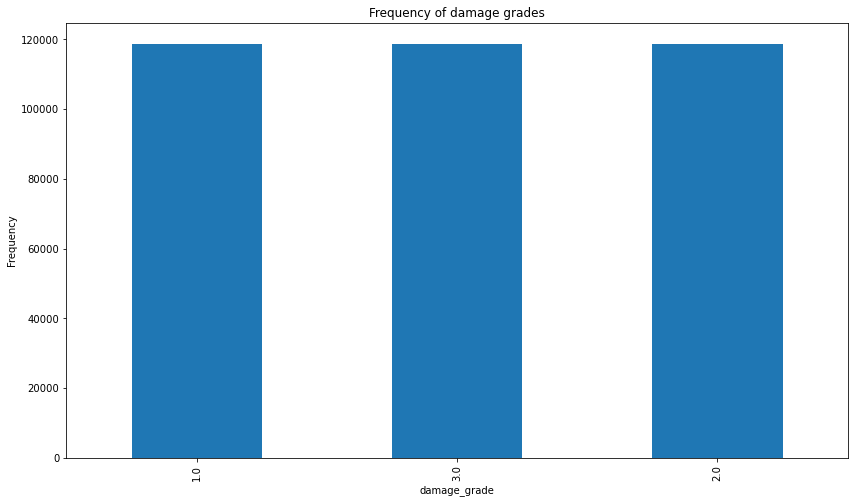

In [10]:
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

# VII. Engineered Models without Hyperparameter Tuning

## Decision Tree ohne Rebalance

In [11]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6555
The F1-Score micro on test set: 0.6555
The F1-Score macro on test set: 0.6084
The Precision-Score on test set: 0.6555
The Recall-Score on test set: 0.6555
Confusion Matrix : 
[[ 2642  2205   323]
 [ 2370 20773  6344]
 [  329  6384 10751]]


## Decision Tree mit Rebalance

In [12]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6533
The F1-Score micro on test set: 0.6533
The F1-Score macro on test set: 0.6019
The Precision-Score on test set: 0.6533
The Recall-Score on test set: 0.6533
Confusion Matrix : 
[[ 2501  2335   334]
 [ 2267 20807  6413]
 [  368  6353 10743]]


## Logistic Regressin ohne Rebalance

In [12]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6464
The F1-Score micro on test set: 0.6464
The F1-Score macro on test set: 0.5587
The Precision-Score on test set: 0.6464
The Recall-Score on test set: 0.6464
Confusion Matrix : 
[[ 1529  3537   104]
 [  998 23151  5338]
 [   61  8390  9013]]


## Logistic Regressin mit Rebalance

In [14]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

The Accuracy on test set: 0.5457
The F1-Score micro on test set: 0.5457
The F1-Score macro on test set: 0.5329
The Precision-Score on test set: 0.5457
The Recall-Score on test set: 0.5457


## xgboost ohne Rebalance

In [22]:
xgb = XGBClassifier(use_label_encoder = True).fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy on test set: 0.7292
The F1-Score micro on test set: 0.7292
The F1-Score macro on test set: 0.6689
The Precision-Score on test set: 0.7292
The Recall-Score on test set: 0.7292


# Featuretools-package

In [18]:
import featuretools as ft

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,foundation_type_h,...,foundation_type_w,roof_type_n,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,district_class_1,district_class_2,district_class_3,district_class_4,age_u_40,age_ue_100
0,802906,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,28830,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,94947,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,590882,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,201944,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,0.133333,0.423966,0.288295,0.250,0.070352,0.191919,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
347465,663567,0.333333,0.985985,0.947481,0.250,0.025126,0.050505,0.166667,1,1,1,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
347466,1049160,0.733333,0.796076,0.613671,0.000,0.050251,0.020202,0.033333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.

In [90]:
# create an entity set with only one entity
es=ft.EntitySet(id="earthquake_data")

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
# add dataset as entity
es = es.entity_from_dataframe(entity_id="damage", dataframe=df, index="building_id",)

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# create normalized entities based on geo_level
es = es.normalize_entity(base_entity_id="damage", new_entity_id="geo_data", index="geo_level_1_id",
                         additional_variables=["geo_level_2_id", "geo_level_3_id"])

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
es

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entityset: earthquake_data
  Entities:
    damage [Rows: 347469, Columns: 71]
    geo_data [Rows: 31, Columns: 3]
  Relationships:
    damage.geo_level_1_id -> geo_data.geo_level_1_id

In [94]:
feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity="damage")

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
feature_matrix

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,...,geo_data.SUM(damage.has_superstructure_cement_mortar_brick),geo_data.SUM(damage.has_superstructure_cement_mortar_stone),geo_data.SUM(damage.has_superstructure_mud_mortar_brick),geo_data.SUM(damage.has_superstructure_mud_mortar_stone),geo_data.SUM(damage.has_superstructure_other),geo_data.SUM(damage.has_superstructure_rc_engineered),geo_data.SUM(damage.has_superstructure_rc_non_engineered),geo_data.SUM(damage.has_superstructure_stone_flag),geo_data.SUM(damage.has_superstructure_timber),geo_data.SUM(damage.height_percentage),geo_data.SUM(damage.land_surface_condition_n),geo_data.SUM(damage.land_surface_condition_o),geo_data.SUM(damage.legal_ownership_status_a),geo_data.SUM(damage.legal_ownership_status_r),geo_data.SUM(damage.legal_ownership_status_v),geo_data.SUM(damage.legal_ownership_status_w),geo_data.SUM(damage.other_floor_type_j),geo_data.SUM(damage.other_floor_type_q),geo_data.SUM(damage.other_floor_type_s),geo_data.SUM(damage.other_floor_type_x),geo_data.SUM(damage.plan_configuration_a),geo_data.SUM(damage.plan_configuration_c),geo_data.SUM(damage.plan_configuration_d),geo_data.SUM(damage.plan_configuration_f),geo_data.SUM(damage.plan_configuration_m),geo_data.SUM(damage.plan_configuration_n),geo_data.SUM(damage.plan_configuration_o),geo_data.SUM(damage.plan_configuration_q),geo_data.SUM(damage.plan_configuration_s),geo_data.SUM(damage.plan_configuration_u),geo_data.SUM(damage.position_j),geo_data.SUM(damage.position_o),geo_data.SUM(damage.position_s),geo_data.SUM(damage.roof_type_n),geo_data.SUM(damage.roof_type_x)
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0.200000,0.125,0.030151,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2187,167,2307,24272,155,1113,1313,124,3424,4403.166667,4150.0,965.0,188.0,62.0,31864.0,371.0,2899.0,23349.0,2852.0,3385.0,18.0,58.0,31473.0,2.0,1.0,2.0,12.0,487.0,20.0,412.0,1655.0,66.0,24065.0,24195.0,3362.0
28830,0.266667,0.125,0.010050,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,766,339,379,23074,561,336,909,641,4313,3143.866667,4646.0,1275.0,223.0,83.0,24972.0,187.0,2964.0,18211.0,864.0,3426.0,15.0,16.0,24208.0,5.0,1.0,4.0,5.0,1014.0,18.0,179.0,1123.0,52.0,17793.0,20485.0,1140.0
94947,0.700000,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,332,165,18,19135,203,95,500,271,3053,2438.633333,1507.0,223.0,108.0,51.0,19234.0,551.0,1335.0,15059.0,440.0,3110.0,4.0,17.0,19382.0,2.0,0.0,1.0,8.0,297.0,6.0,227.0,375.0,4.0,16862.0,10537.0,467.0
590882,0.733333,0.125,0.010050,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,541,539,285,7439,38,146,522,330,2111,716.566667,972.0,282.0,195.0,17.0,8119.0,27.0,1739.0,4657.0,242.0,1720.0,9.0,15.0,8085.0,0.0,1.0,0.0,0.0,194.0,11.0,43.0,232.0,29.0,7359.0,7092.0,333.0
201944,0.366667,0.250,0.030151,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1190,132,4586,4635,235,187,4

In [96]:
df_features=feature_matrix.copy()
scaler = MinMaxScaler()
df_features[df_features.columns] = scaler.fit_transform(df_features[df_features.columns])
df_features['damage_grade']=feature_matrix['damage_grade']

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
df_features

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,...,geo_data.SUM(damage.has_superstructure_cement_mortar_brick),geo_data.SUM(damage.has_superstructure_cement_mortar_stone),geo_data.SUM(damage.has_superstructure_mud_mortar_brick),geo_data.SUM(damage.has_superstructure_mud_mortar_stone),geo_data.SUM(damage.has_superstructure_other),geo_data.SUM(damage.has_superstructure_rc_engineered),geo_data.SUM(damage.has_superstructure_rc_non_engineered),geo_data.SUM(damage.has_superstructure_stone_flag),geo_data.SUM(damage.has_superstructure_timber),geo_data.SUM(damage.height_percentage),geo_data.SUM(damage.land_surface_condition_n),geo_data.SUM(damage.land_surface_condition_o),geo_data.SUM(damage.legal_ownership_status_a),geo_data.SUM(damage.legal_ownership_status_r),geo_data.SUM(damage.legal_ownership_status_v),geo_data.SUM(damage.legal_ownership_status_w),geo_data.SUM(damage.other_floor_type_j),geo_data.SUM(damage.other_floor_type_q),geo_data.SUM(damage.other_floor_type_s),geo_data.SUM(damage.other_floor_type_x),geo_data.SUM(damage.plan_configuration_a),geo_data.SUM(damage.plan_configuration_c),geo_data.SUM(damage.plan_configuration_d),geo_data.SUM(damage.plan_configuration_f),geo_data.SUM(damage.plan_configuration_m),geo_data.SUM(damage.plan_configuration_n),geo_data.SUM(damage.plan_configuration_o),geo_data.SUM(damage.plan_configuration_q),geo_data.SUM(damage.plan_configuration_s),geo_data.SUM(damage.plan_configuration_u),geo_data.SUM(damage.position_j),geo_data.SUM(damage.position_o),geo_data.SUM(damage.position_s),geo_data.SUM(damage.roof_type_n),geo_data.SUM(damage.roof_type_x)
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0.200000,0.125,0.030151,0.050505,0.100000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.261551,0.210797,0.396869,0.892605,0.249180,1.000000,0.697501,0.067172,0.233461,1.000000,0.892757,0.756098,0.078008,0.170330,1.000000,0.572531,0.257014,1.000000,1.000000,0.614159,0.327273,0.878788,1.000000,0.4,0.076923,0.153846,0.235294,0.478218,0.176991,0.392755,0.570787,0.064897,0.957009,1.000000,0.777881
28830,0.266667,0.125,0.010050,0.070707,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.091453,0.431877,0.065199,0.847932,0.914754,0.301887,0.482722,0.347237,0.295304,0.711313,1.000000,1.000000,0.092531,0.228022,0.781310,0.288580,0.262860,0.777730,0.302701,0.621757,0.272727,0.242424,0.766826,1.0,0.076923,0.307692,0.098039,1.000000,0.159292,0.170639,0.387086,0.051131,0.704065,0.845410,0.263767
94947,0.700000,0.125,0.010050,0.040404,0.100000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.039502,0.208226,0.003097,0.701048,0.327869,0.085355,0.265284,0.146804,0.207652,0.549643,0.321297,0.172305,0.044813,0.140110,0.599238,0.850309,0.116367,0.641374,0.153981,0.563195,0.072727,0.257576,0.611933,0.4,0.000000,0.076923,0.156863,0.290099,0.053097,0.216397,0.128798,0.003933,0.666519,0.430893,0.108052
590882,0.733333,0.125,0.010050,0.

In [98]:
df_features['damage_grade']

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


building_id
802906     3.0
28830      2.0
94947      3.0
590882     2.0
201944     3.0
          ... 
310028     NaN
663567     NaN
1049160    NaN
442785     NaN
501372     NaN
Name: damage_grade, Length: 347469, dtype: float64

In [99]:
#Korrelation
correlated_features = set()
correlation_matrix = df_features.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(f"Drop the following features: {correlated_features}")
#drop correlated features
df_features=df_features.drop(columns=correlated_features)

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The following features are correlated: geo_data.MAX(damage.district_class_1) and district_class_1. Correlation = 1.0
The following features are correlated: geo_data.MAX(damage.district_class_2) and district_class_2. Correlation = 1.0
The following features are correlated: geo_data.MAX(damage.district_class_3) and district_class_3. Correlation = 1.0
The following features are correlated: geo_data.MAX(damage.district_class_4) and district_class_4. Correlation = 1.0
The following features are correlated: geo_data.MAX(damage.ground_floor_type_m) and geo_data.MAX(damage.foundation_type_h). Correlation = 0.94
The following features are correlated: geo_data.MAX(damage.has_secondary_use_other) and geo_data.MAX(damage.age_ue_100). Correlation = 1.0
The following features are correlated: geo_data.MAX(damage.has_secondary_use_rental) and geo_data.MAX(damage.age_ue_100). Correlation = 1.0
The following features are correlated: geo_data.MAX(damage.has_secondary_use_rental) and geo_data.MAX(damage.h

The following features are correlated: geo_data.MEAN(damage.plan_configuration_s) and geo_data.MEAN(damage.foundation_type_w). Correlation = 0.84
The following features are correlated: geo_data.MEAN(damage.plan_configuration_s) and geo_data.MEAN(damage.has_superstructure_bamboo). Correlation = 0.87
The following features are correlated: geo_data.MEAN(damage.plan_configuration_s) and geo_data.MEAN(damage.plan_configuration_o). Correlation = 0.84
The following features are correlated: geo_data.MEAN(damage.plan_configuration_u) and geo_data.MEAN(damage.plan_configuration_o). Correlation = 0.86
The following features are correlated: geo_data.MEAN(damage.plan_configuration_u) and geo_data.MEAN(damage.plan_configuration_s). Correlation = 0.81
The following features are correlated: geo_data.MEAN(damage.position_j) and geo_data.MEAN(damage.age_u_40). Correlation = 0.86
The following features are correlated: geo_data.MEAN(damage.position_j) and geo_data.MEAN(damage.has_superstructure_adobe_mud)

The following features are correlated: geo_data.SKEW(damage.land_surface_condition_o) and geo_data.MEAN(damage.land_surface_condition_o). Correlation = 0.9
The following features are correlated: geo_data.SKEW(damage.other_floor_type_j) and geo_data.MEAN(damage.count_floors_pre_eq). Correlation = 0.91
The following features are correlated: geo_data.SKEW(damage.other_floor_type_j) and geo_data.MEAN(damage.other_floor_type_j). Correlation = 0.91
The following features are correlated: geo_data.SKEW(damage.other_floor_type_j) and geo_data.MEAN(damage.other_floor_type_q). Correlation = 0.83
The following features are correlated: geo_data.SKEW(damage.other_floor_type_q) and geo_data.MEAN(damage.ground_floor_type_f). Correlation = 0.83
The following features are correlated: geo_data.SKEW(damage.other_floor_type_q) and geo_data.MEAN(damage.other_floor_type_j). Correlation = 0.9
The following features are correlated: geo_data.SKEW(damage.other_floor_type_q) and geo_data.MEAN(damage.other_floor_t

The following features are correlated: geo_data.STD(damage.foundation_type_w) and geo_data.STD(damage.foundation_type_r). Correlation = 0.84
The following features are correlated: geo_data.STD(damage.ground_floor_type_f) and geo_data.MEAN(damage.ground_floor_type_f). Correlation = 0.92
The following features are correlated: geo_data.STD(damage.ground_floor_type_f) and geo_data.SKEW(damage.foundation_type_u). Correlation = 0.81
The following features are correlated: geo_data.STD(damage.ground_floor_type_f) and geo_data.SKEW(damage.ground_floor_type_f). Correlation = 0.99
The following features are correlated: geo_data.STD(damage.ground_floor_type_m) and geo_data.MEAN(damage.ground_floor_type_m). Correlation = 0.97
The following features are correlated: geo_data.STD(damage.ground_floor_type_v) and geo_data.MEAN(damage.foundation_type_i). Correlation = 0.84
The following features are correlated: geo_data.STD(damage.ground_floor_type_v) and geo_data.MEAN(damage.foundation_type_u). Correlat

The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.MEAN(damage.foundation_type_i). Correlation = 0.82
The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.MEAN(damage.has_superstructure_rc_engineered). Correlation = 0.85
The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.MEAN(damage.other_floor_type_s). Correlation = 0.97
The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.MEAN(damage.roof_type_x). Correlation = 0.94
The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.SKEW(damage.position_j). Correlation = 0.84
The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.STD(damage.foundation_type_i). Correlation = 0.88
The following features are correlated: geo_data.STD(damage.other_floor_type_s) and geo_data.STD(damage.has_superstructure_rc_engineered). Co

The following features are correlated: geo_data.SUM(damage.district_class_4) and geo_data.SUM(damage.count_floors_pre_eq). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.district_class_4) and geo_data.SUM(damage.damage_grade). Correlation = 0.83
The following features are correlated: geo_data.SUM(damage.foundation_type_h) and geo_data.STD(damage.foundation_type_h). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.foundation_type_i) and geo_data.COUNT(damage). Correlation = 0.83
The following features are correlated: geo_data.SUM(damage.foundation_type_i) and geo_data.MEAN(damage.has_superstructure_rc_engineered). Correlation = 0.8
The following features are correlated: geo_data.SUM(damage.foundation_type_i) and geo_data.SUM(damage.age). Correlation = 0.85
The following features are correlated: geo_data.SUM(damage.foundation_type_i) and geo_data.SUM(damage.age_u_40). Correlation = 0.81
The following features are correlated: geo

The following features are correlated: geo_data.SUM(damage.has_secondary_use_gov_office) and geo_data.STD(damage.has_secondary_use_gov_office). Correlation = 0.8
The following features are correlated: geo_data.SUM(damage.has_secondary_use_gov_office) and geo_data.SUM(damage.has_secondary_use_agriculture). Correlation = 0.81
The following features are correlated: geo_data.SUM(damage.has_secondary_use_hotel) and geo_data.COUNT(damage). Correlation = 0.95
The following features are correlated: geo_data.SUM(damage.has_secondary_use_hotel) and geo_data.MAX(damage.height_percentage). Correlation = 0.85
The following features are correlated: geo_data.SUM(damage.has_secondary_use_hotel) and geo_data.SKEW(damage.plan_configuration_f). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.has_secondary_use_hotel) and geo_data.SUM(damage.age). Correlation = 0.83
The following features are correlated: geo_data.SUM(damage.has_secondary_use_hotel) and geo_data.SUM(damage.age_

The following features are correlated: geo_data.SUM(damage.has_superstructure_rc_engineered) and geo_data.MEAN(damage.has_superstructure_rc_engineered). Correlation = 0.88
The following features are correlated: geo_data.SUM(damage.has_superstructure_rc_engineered) and geo_data.STD(damage.has_superstructure_rc_engineered). Correlation = 0.83
The following features are correlated: geo_data.SUM(damage.has_superstructure_rc_engineered) and geo_data.SUM(damage.area_percentage). Correlation = 0.8
The following features are correlated: geo_data.SUM(damage.has_superstructure_rc_engineered) and geo_data.SUM(damage.foundation_type_i). Correlation = 0.95
The following features are correlated: geo_data.SUM(damage.has_superstructure_rc_engineered) and geo_data.SUM(damage.foundation_type_u). Correlation = 0.81
The following features are correlated: geo_data.SUM(damage.has_superstructure_rc_engineered) and geo_data.SUM(damage.ground_floor_type_v). Correlation = 0.84
The following features are correla

The following features are correlated: geo_data.SUM(damage.other_floor_type_x) and geo_data.SUM(damage.age_u_40). Correlation = 0.87
The following features are correlated: geo_data.SUM(damage.other_floor_type_x) and geo_data.SUM(damage.area_percentage). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.other_floor_type_x) and geo_data.SUM(damage.count_families). Correlation = 0.85
The following features are correlated: geo_data.SUM(damage.other_floor_type_x) and geo_data.SUM(damage.has_secondary_use_hotel). Correlation = 0.81
The following features are correlated: geo_data.SUM(damage.other_floor_type_x) and geo_data.SUM(damage.has_superstructure_timber). Correlation = 0.81
The following features are correlated: geo_data.SUM(damage.other_floor_type_x) and geo_data.SUM(damage.legal_ownership_status_v). Correlation = 0.81
The following features are correlated: geo_data.SUM(damage.plan_configuration_c) and geo_data.SUM(damage.foundation_type_i). Correlation = 0.

The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.has_secondary_use_industry). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.has_secondary_use_institution). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.has_superstructure_mud_mortar_stone). Correlation = 0.8
The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.has_superstructure_rc_non_engineered). Correlation = 0.82
The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.height_percentage). Correlation = 0.92
The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.land_surface_condition_n). Correlation = 0.86
The following features are correlated: geo_data.SUM(damage.roof_type_n) and geo_data.SUM(damage.legal_ownership_status_v). Cor

In [105]:
df_features=df_features.drop(columns=['geo_data.MEAN(damage.damage_grade)'])

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
df_features=df_features.drop(columns=['geo_data.SKEW(damage.damage_grade)'])

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
df_features=df_features.reset_index()

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
data_train, target_train, data_test = split_data(df_features)
data_train

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level_0,index,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,foundation_type_h,foundation_type_i,foundation_type_r,...,geo_data.SKEW(damage.has_secondary_use_rental),geo_data.SKEW(damage.has_secondary_use_school),geo_data.SKEW(damage.has_superstructure_adobe_mud),geo_data.SKEW(damage.has_superstructure_bamboo),geo_data.SKEW(damage.has_superstructure_cement_mortar_stone),geo_data.SKEW(damage.has_superstructure_mud_mortar_brick),geo_data.SKEW(damage.has_superstructure_other),geo_data.SKEW(damage.has_superstructure_rc_engineered),geo_data.SKEW(damage.has_superstructure_stone_flag),geo_data.SKEW(damage.legal_ownership_status_a),geo_data.SKEW(damage.legal_ownership_status_r),geo_data.SKEW(damage.legal_ownership_status_v),geo_data.SKEW(damage.legal_ownership_status_w),geo_data.SKEW(damage.plan_configuration_a),geo_data.SKEW(damage.plan_configuration_c),geo_data.SKEW(damage.plan_configuration_m),geo_data.SKEW(damage.plan_configuration_n),geo_data.SKEW(damage.plan_configuration_o),geo_data.SKEW(damage.plan_configuration_s),geo_data.SKEW(damage.position_o),geo_data.STD(damage.age),geo_data.STD(damage.damage_grade),geo_data.STD(damage.district_class_1),geo_data.STD(damage.district_class_2),geo_data.STD(damage.district_class_3),geo_data.STD(damage.district_class_4),geo_data.STD(damage.other_floor_type_q),geo_data.SUM(damage.age_ue_100),geo_data.SUM(damage.ground_floor_type_x),geo_data.SUM(damage.has_secondary_use_health_post),geo_data.SUM(damage.has_secondary_use_other),geo_data.SUM(damage.has_superstructure_cement_mortar_stone),geo_data.SUM(damage.has_superstructure_other),geo_data.SUM(damage.has_superstructure_stone_flag),geo_data.SUM(damage.plan_configuration_a)
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0,0,0.200000,0.125,0.030151,0.050505,0.100000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.214524,0.224406,0.097849,1.000000,0.435660,0.074293,0.587808,0.111736,0.406749,0.114975,0.441118,0.812234,0.140576,0.304278,0.293100,1.000000,0.902402,0.372766,0.698680,0.313318,0.408315,0.809756,0.0,0.0,0.0,0.0,0.480137,0.551306,0.335307,0.500,0.289199,0.210797,0.249180,0.067172,0.327273
28830,1,1,0.266667,0.125,0.010050,0.070707,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.316958,0.281090,0.212020,0.508857,0.221840,0.175117,0.221390,0.186181,0.153230,0.093046,0.336870,0.813487,0.176413,0.295103,0.494950,0.885381,0.564884,0.511435,0.651978,0.312525,0.224366,0.842207,0.0,0.0,0.0,0.0,0.498645,0.116604,0.731944,0.875,0.271777,0.431877,0.914754,0.347237,0.272727
94947,2,2,0.700000,0.125,0.010050,0.040404,0.100000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.267625,0.291715,0.324137,0.822379,0.316408,0.719508,0.372775,0.313903,0.212389,0.118930,0.380731,0.865988,0.088113,0.506039,0.424808,0.000000,1.000000,0.357716,1.000000,1.000000,0.205078,0.744813,0.0,0.0,0.0,0.0,0.273050,0.161381,0.295998,0.250,0.184669,0.208226,0.327869,0.146804,0.072727
590882,3,3,0.733333,0.125,0.010050,0.050505,0.100000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.

In [114]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42)

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
xgb = XGBClassifier(use_label_encoder = True).fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy on test set: 0.6929
The F1-Score micro on test set: 0.6929
The F1-Score macro on test set: 0.6270
The Precision-Score on test set: 0.6929
The Recall-Score on test set: 0.6929


C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Feature: 0 level_0, Score: 0.0007253045914694667
Feature: 1 index, Score: 0.0
Feature: 2 geo_level_1_id, Score: 0.009428700432181358
Feature: 3 count_floors_pre_eq, Score: 0.0017619883874431252
Feature: 4 age, Score: 0.0023154353257268667
Feature: 5 area_percentage, Score: 0.0011064482387155294
Feature: 6 height_percentage, Score: 0.0013507460243999958
Feature: 7 has_superstructure_adobe_mud, Score: 0.0017757276073098183
Feature: 8 has_superstructure_mud_mortar_stone, Score: 0.016407115384936333
Feature: 9 has_superstructure_stone_flag, Score: 0.0031844780314713717
Feature: 10 has_superstructure_cement_mortar_stone, Score: 0.0016651637852191925
Feature: 11 has_superstructure_mud_mortar_brick, Score: 0.0035059701185673475
Feature: 12 has_superstructure_cement_mortar_brick, Score: 0.005267084576189518
Feature: 13 has_superstructure_timber, Score: 0.0019393919501453638
Feature: 14 has_superstructure_bamboo, Score: 0.0014313842402771115
Feature: 15 has_superstructure_rc_non_engineered, Sco

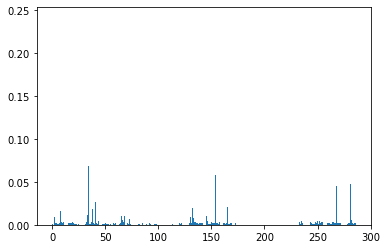

In [116]:
# xgboost for feature importance on a regression problem
# get importance
importance = xgb.feature_importances_
# summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i} {data_train.columns[i]}, Score: {v}')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


## hyperparameter

In [118]:
#grid for xgboost
# Create the random grid
random_grid= {'min_child_weight':[ 4,5,6,7 ], 
              'gamma':[i/10.0 for i in range(1,4)],  
              'subsample':[1],
              'colsample_bytree':[1],
              'max_depth': [8]}

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV
# First create the base model to tune
xgbm = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator=xgbm, param_distributions=random_grid, n_iter=30, cv=5, verbose=2, random_state=42,scoring='f1_micro')
# Fit the random search model
rf_random.fit(data_train, target_train)

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:30:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.9min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s
C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.5min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.6min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.6min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.5min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.4min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.5min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.2min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.2min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.6min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.5min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.8min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.7min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.8min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.7min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1, total= 4.4min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.1, colsample_bytree=1, total= 5.0min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1, total= 4.6min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.0min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1, total= 4.9min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.0min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.2, colsample_bytree=1, total= 6.9min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1, total= 6.3min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1, total= 6.3min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1, total= 6.8min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1, total= 7.1min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.2, colsample_bytree=1, total= 7.6min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1, total= 7.1min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1, total= 6.2min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1, total= 6.1min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.3min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.2min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.0min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.2min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1, total= 5.3min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1, total= 4.6min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.2, colsample_bytree=1, total= 4.8min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.8min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.4min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.2min
[CV] subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:14:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=4, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.4min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:18:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.2min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:27:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.1min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.1min
[CV] subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=5, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.2min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.5min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1, total= 5.7min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1, total= 5.7min
[CV] subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=6, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.4min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.5min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.2min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1, total= 4.3min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1, total= 5.8min
[CV] subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1 


C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, min_child_weight=7, max_depth=8, gamma=0.3, colsample_bytree=1, total= 5.4min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 298.1min finished
C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

In [121]:
best_random = rf_random.best_estimator_
best_random.fit(data_train, target_train)
prediction = best_random.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy on test set: 0.6967
The F1-Score micro on test set: 0.6967
The F1-Score macro on test set: 0.6318
The Precision-Score on test set: 0.6967
The Recall-Score on test set: 0.6967


In [122]:
rf_random.best_estimator_

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)